In [74]:
import sys
import os
#sys.path.append('D:\\software_git_repos\\cofe-python-analysis-tools\\utils_meinhold')
sys.path.append('../utils_meinhold')
#sys.path.append('D:\\software_git_repos\\cofe-python-analysis-tools\\utils_zonca')
sys.path.append('../utils_zonca')
#sys.path.append('D:\\software_git_repos\\cofe-python-analysis-tools\\utils_zonca\\pointing')
sys.path.append('../utils_zonca/pointing')
#sys.path.append('D:\\software_git_repos\\greenpol')
sys.path.append('../')
#sys.path.append('D:\\software_git_repos\\greenpol\\telescope_control\\')
sys.path.append('../telescope_control')
#sys.path.append('D:\\software_git_repos\\greenpol\\telescope_control\\VtoT\\')
sys.path.append('../VtoT')
import realtime_gp as rt
import numpy as np
import datetime 
import h5py
import pandas as pd
from pointingtools import compute_parallactic_angle, altaz2ha 
from planets import getlocation
import warnings
from astropy.coordinates import AltAz, Angle, EarthLocation, ICRS, SkyCoord, frame_transform_graph
from astropy import units as u
import ephem
import matplotlib.pyplot as plt
import time
from datetime import datetime

import Tkinter,tkFileDialog

from Tkinter import *
import ttk

import pickle
import glob

import cPickle

%pylab
%matplotlib auto

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
Using matplotlib backend: TkAgg


c:\users\labuser\anaconda3\envs\py27\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Text', 'Button', 'datetime', 'Widget', 'diff', 'var']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def get_pointing_files(filelist=None):

    if filelist==None:
        root=Tkinter.Tk()
        filelist = list(tkFileDialog.askopenfilenames(\
        initialdir='D://software_git_repos/greenpol/telescope_control/data_aquisition/pointing_data/',parent=root,title='Choose a set of files'))
        root.destroy()
    filelist.sort()
    
    return filelist

In [3]:
def read_some_data(filelist=None):

    if filelist==None:
        root=Tkinter.Tk()
        filelist = list(tkFileDialog.askopenfilenames(\
        initialdir='D://software_git_repos/greenpol/telescope_control/data_aquisition/demod_data/',parent=root,title='Choose a set of files'))
        root.destroy()
    filelist.sort()
    
    dlist=[]
    for f in filelist:
        hf=h5py.File(f)
        dlist.append(hf['demod_data'])
    d=np.concatenate(dlist)
    hf.close() 

    datadict=d
        
    return datadict, filelist

In [37]:
def get_file_times(fld):
    startfile = fld[0][:43]+fld[0][49:-2]+'dat'
    endfile = fld[-1][:43]+fld[-1][49:-2]+'dat'
    
    #starttime = os.path.getctime(startfile)
    starttime= os.stat(startfile).st_mtime + 7*3600
    starttime = datetime.datetime.fromtimestamp(starttime)
    
    #endtime = os.path.getctime(endfile)
    endtime= os.stat(endfile).st_mtime + 7*3600
    endtime = datetime.datetime.fromtimestamp(endtime)
    
    return starttime, endtime

In [119]:
def fileStruct(n_array, chan, starttime, endtime):

    fpath = "C:/software_git_repos/polaris/polaris_data/level1"
    os.chdir(fpath)
    yrmoday = starttime.strftime('%Y%m%d')
    path = '-'.join((starttime.strftime('%H_%M_%S'), endtime.strftime('%H_%M_%S')+'222222222'))
    path = '-'.join((chan, path))
    print 'start time: ', starttime
    print 'end time: ', endtime
    print 'elapsed time: ', (endtime - starttime).total_seconds(), 'sec'
    if not os.path.exists(yrmoday):#this is the first file being created for that time
        os.makedirs(yrmoday)
        #set index to 0

    path = '/'.join((yrmoday,path))
    path = '.'.join((path,"h5"))
    with h5py.File(str(path).replace("pkl","h5"), mode="w") as f:
        f.create_dataset("data", data=n_array.to_records(index=False))

In [6]:
def round_fraction(number, res):
    amount = int(number/res)*res
    remainder = number - amount
    return amount if remainder < res/2. else amount+res

In [7]:
def convert_gpstime(starttime, gpstime, ltoffset=0, bits_to_ms=2**24, format='seconds', ttype = 'utc', singletime=False):

    #function to convert gpstime to UTC time or local time

    #universal time day
    ltoffset = ltoffset*60*60
    utcday = starttime + datetime.timedelta(0, ltoffset)

    #days since last sunday
    idx = (utcday.weekday() + 1) % 7

    #date of previous sunday in universal coord
    sunday = utcday - datetime.timedelta(idx) 

    syear = int(str(sunday)[:4])
    smonth = int(str(sunday)[5:7])
    sday = int(str(sunday)[8:10])
    
    sunday = datetime.datetime(syear, smonth, sday, 0, 0, 0)

    #seconds since last sunday
    sundaysec = (utcday - sunday).total_seconds()

    #convert to seconds
    bits_to_sec = bits_to_ms/1000
    
    #number of wraps so far
    numwraps = int(sundaysec/bits_to_sec)
    
    #time of last wrap
    gpsstarttime = sunday + datetime.timedelta(0, numwraps*bits_to_sec)
    
    #convert gps starttime to timestamp
    #gpsstarttime = (gpsstarttime-datetime.datetime(1970,1,1)).total_seconds()
    gpsstarttime = time.mktime(gpsstarttime.timetuple())
    
    if singletime == False:
        #find all wrap points in current data set
        gpsdiff = np.diff(gpstime)
        iwrap = np.where(gpsdiff < -2**24/1000/2)[0]
        #iwrap = np.where(abs(gpsdiff) > 2**24/1000/2)[0]

        #unwrap gpstime
        for w in iwrap:
            gpstime[w+1:] = gpstime[w+1:] + gpstime[w]

    if ttype == 'utc':
        ltoffset = 0
    #gpstime gives seconds since starting point
    dtime = gpsstarttime + gpstime - ltoffset

        
    if format == 'datetime':
        if singletime == False:
            t = []
            for i in range(len(dtime)):
                t.append(datetime.datetime.fromtimestamp(dtime[i]))
        else:
            t = datetime.datetime.fromtimestamp(dtime)
        
        return t, dtime
    
    else:
        return dtime

    '''
    dtime = []
     
    for i in range(len(gpstime)):
    #for i in range(0,1):
        
        if i>0:
            if abs(gpstime[i] - gpstime[i-1]) > 2**24/1000/2:
                print 'it got here'
                gpstime[i:] = gpstime[i:] + gpstime[i-1]
                
        #gpstime gives seconds since starting point
        t = gpsstarttime + datetime.timedelta(0,gpstime[i]) - datetime.timedelta(0, ltoffset)

        if format == 'seconds':
            timestamp = (t-datetime.datetime(1970,1,1)).total_seconds()
            dtime.append(timestamp)
        else:
            dtime.append(t)
          
    return dtime
    '''

In [134]:
ddict={}

In [135]:
dd, fld = read_some_data()

In [136]:
flp = get_pointing_files()
pp = rt.get_h5_pointing(flp)

In [125]:
pp.keys()

['gpstime',
 'el',
 'computer time',
 'el offset',
 'Calibrator',
 'H2',
 'H3',
 'H1',
 'Amplifier',
 'az offset',
 'Cooler',
 'flag',
 'x tilt',
 'Phidget Temp',
 'y tilt',
 'az',
 'Backend TSS']

In [126]:
figure()
time = (pp['gpstime'] - pp['gpstime'][0])/1000./3600.
plot(time, pp['Backend TSS'])

In [133]:
print (pp['gpstime'].max() - pp['gpstime'].min())/1000./3600.

1.2070777777777777


In [131]:
figure()
plot(pp['gpstime'])

In [128]:
print pp['gpstime']

[293303655 293303677 293303701 ... 297648421 297648457 297649135]


In [137]:
combined = rt.combine_cofe_h5_pointing(dd,pp)

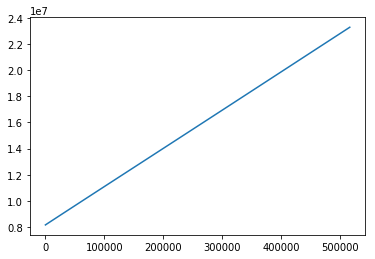

In [58]:
plot(combined['gpstime'])

In [113]:
print type(dd['rev'])

<type 'numpy.ndarray'>


In [40]:
print fld[0]

J:/software_git_repos/polaris/polaris_data/demod_data/20191025/07425100.h5


In [59]:
starttime, endtime = get_file_times(fld)

print starttime
print endtime

2019-10-30 09:26:34.617700
2019-10-30 13:38:17.860556


In [138]:
chan = 'ch0'
var = 'Q'
LOCATION = 'Sedgwick'

#gain in kelvin per volt
changain = {'ch0':-3.1, 'ch4':-9.47, 'ch8':-11.1}

In [61]:
#offset between local time and utctime in hours
ltoffset = 0

#seconds since last sunday utc
gpstime = dd['rev']/1000#(combined['gpstime'])/1000

In [25]:
print type(gpstime)
print type(time)

<type 'numpy.ndarray'>
<type 'module'>


In [26]:
gpstime = dd['rev']
diff = np.diff(gpstime)
ijump = np.where(diff > 1e4)[0][0]
dmax = diff.max()
dmin = diff.min()
print gpstime[ijump:ijump+2]
gpstime[ijump+1:] -= (dmax - dmin)
print gpstime[ijump:ijump+2]
print diff

IndexError: index 0 is out of bounds for axis 0 with size 0

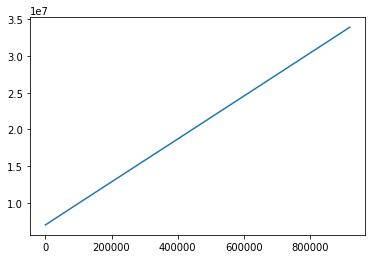

In [44]:
plot(dd['rev'])

In [62]:
gpstime = dd['rev']/1000#(combined['gpstime'])/1000
dtime = convert_gpstime(starttime, gpstime, ltoffset, format = 'datetime', ttype = 'ltc')[0]
tdiffe = (dtime[-1] - endtime).total_seconds()
tdiffs = (dtime[0] - starttime).total_seconds()
print 'file start time: ', starttime
print 'gps converted start time: ', dtime[0]
print 'amount off in seconds: ', tdiffs
print 'file end time: ', endtime
print 'gps converted end time: ', dtime[-1]
print 'amount off in seconds: ', tdiffe

file start time:  2019-10-30 09:26:34.617700
gps converted start time:  2019-10-30 09:29:21.901000
amount off in seconds:  167.2833
file end time:  2019-10-30 13:38:17.860556
gps converted end time:  2019-10-30 13:41:35.748000
amount off in seconds:  197.887444


In [63]:
#gpstime = dd['rev']/1000#(combined['gpstime'])/1000
dtime, utime = convert_gpstime(starttime, gpstime, ltoffset, format = 'datetime')

In [64]:
from astropy.utils.iers import conf
conf.auto_max_age = None

In [65]:
AZ = combined['az']
EL = combined['el'] 

location = getlocation(LOCATION)

t1 = time.time()
#create ra dec sky object
azel = SkyCoord(az = AZ, alt = EL, obstime = dtime, location = location, frame = 'altaz', unit='deg')
t2 = time.time()
print t2-t1
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #convert from ra dec to az/el for pointing
    radec = azel.icrs
print time.time()-t2
ra = radec.ra.rad
dec = radec.dec.rad

1.80900001526
125.699999809


In [66]:
AZ = np.radians(AZ)
EL = np.radians(EL)

In [67]:
lat = location.latitude.rad
ha = altaz2ha(EL, AZ, lat)
psi = compute_parallactic_angle(ha, lat, dec)

        Use `lat` instead. [astropy.utils.decorators]


In [68]:
#need to figure out units on TIME in andreas test file

In [69]:
#h5data=pd.DataFrame({"THETA" : np.pi/2 - THETA })
h5data=pd.DataFrame({"TIME" : utime}) 
h5data["PHI"] = ra
h5data["THETA"] = np.pi/2 - dec
h5data["PSI"] = psi
h5data["FLAG"] = np.zeros(len(dtime)) 
h5data["TEMP"] = combined['sci_data'][chan]['T']*changain[chan]
h5data["Q"] = combined['sci_data'][chan]['Q']*changain[chan]
h5data["U"] = combined['sci_data'][chan]['U']*changain[chan]

In [120]:
fileStruct(h5data_2days, chan, starttime, endtime)

start time:  2019-10-30 09:26:34.617700
end time:  2019-10-30 13:38:17.860556
elapsed time:  15103.242856 sec


In [112]:
print len(hf1['data']['PHI'])
print len(hf2['data']['PHI'])
print len(hf1['data']['PHI'])+len(hf2['data']['TIME'])
print len(np.concatenate([hf1['data']['PHI'], hf2['data']['PHI']]))

921154
515966
1437120
1437120


In [113]:
print len(hf1['data']['PHI'])
print len(hf2['data']['PHI'])
print len(hf1['data']['PHI'])+len(hf2['data']['TIME'])
print len(np.concatenate([hf1['data']['PHI'], hf2['data']['PHI']]))

921154
515966
1437120
1437120


In [109]:
f1 = 'C:/software_git_repos/polaris/polaris_data/level1/20191025/ch0-07_43_20-15_11_19.h5'
f2 = 'C:/software_git_repos/polaris/polaris_data/level1/20191030/ch0-09_26_34-13_38_17.h5'
hf1 = h5py.File(f1)
hf2 = h5py.File(f2)

a = np.concatenate([hf1['data']['TIME'], hf2['data']['TIME']])

In [121]:
figure()
plot(hf1['data']['Q'])
plot(hf2['data']['Q'])

ValueError: Not a location (invalid object ID)

In [118]:
print h5data.keys()[0]
f1 = 'C:/software_git_repos/polaris/polaris_data/level1/20191025/ch0-07_43_20-15_11_19.h5'
f2 = 'C:/software_git_repos/polaris/polaris_data/level1/20191030/ch0-09_26_34-13_38_17.h5'
hf1 = h5py.File(f1)
hf2 = h5py.File(f2)

TIME = np.concatenate([hf1['data']['TIME'], hf2['data']['TIME']])
PHI = np.concatenate([hf1['data']['PHI'], hf2['data']['PHI']])
THETA = np.concatenate([hf1['data']['THETA'], hf2['data']['THETA']])
PSI = np.concatenate([hf1['data']['PSI'], hf2['data']['PSI']])
FLAG = np.concatenate([hf1['data']['FLAG'], hf2['data']['FLAG']])
TEMP = np.concatenate([hf1['data']['TEMP']*4.4/3.1, hf2['data']['TEMP']])
Q = np.concatenate([hf1['data']['Q']*4.4/3.1, hf2['data']['Q']])
U = np.concatenate([hf1['data']['U']*4.4/3.1, hf2['data']['U']])


h5data_2days=pd.DataFrame({"TIME" : TIME}) 
h5data_2days["PHI"] = PHI
h5data_2days["THETA"] = THETA
h5data_2days["PSI"] = PSI
h5data_2days["FLAG"] = FLAG
h5data_2days["TEMP"] = TEMP
h5data_2days["Q"] = Q
h5data_2days["U"] = U

hf1.close()
hf2.close()

TIME


In [80]:
print hf1

<Closed HDF5 file>


In [ ]:
def read_some_data(filelist=None):

    if filelist==None:
        root=Tkinter.Tk()
        filelist = list(tkFileDialog.askopenfilenames(\
        initialdir='D://software_git_repos/greenpol/telescope_control/data_aquisition/demod_data/',parent=root,title='Choose a set of files'))
        root.destroy()
    filelist.sort()
    
    dlist=[]
    for f in filelist:
        hf=h5py.File(f)
        dlist.append(hf['demod_data'])
    d=np.concatenate(dlist)
    hf.close() 

    datadict=d
        
    return datadict, filelist

In [51]:
figure()
plot(AZ)

In [64]:
def plotnow_azelsig(data, az, el, chan, var, res, minmax=None, radec=False, supply_index=False):
    #flp=select_h5(fpath,yrmoday,st_hour,st_minute,ed_hour,ed_minute)
    #fld_demod, fld =select_dat(fpath,yrmoday,st_hour,st_minute,ed_hour,ed_minute)
    #i=0
    #while len(flp)<3:
    #	i+=1
    #	flp=select_h5(fpath,yrmoday,st_hour,int(st_minute)-i,ed_hour,int(ed_minute)+i)

    #pp=get_h5_pointing(flp)
    ##dd=get_demodulated_data_from_list(fld,supply_index=supply_index)
    #dd=get_all_demodulated_data(fld_demod, fld)	
    #combined=combine_cofe_h5_pointing(dd,pp)

    #synchronized data az and el values
    az1, el1 = az, el
    data = data

    #convert to temp for cryo sensors
    if chan == 12:
        data = convert.convert(data, 'i')
    if chan == 13:
        data = convert.convert(data, 'e')
    if chan == 14:
        data = convert.convert(data, 'h')
    if chan == 15:
        data = convert.convert(data, 'l')

    steps = len(data)

    #set az/el resolution
    dx = res
    dy = res

    #set up bins/grid
    x, y = np.arange(0., 360.+dx, dx), np.arange(0., 90. + dy, dy)
    AZ, EL = np.meshgrid(x, y)

    #small number for comparing floats
    epsilon = 1e-6

    #set up matrix for signal 
    z1 = np.zeros(len(x)*len(y))
    sig = np.reshape(z1, (len(y), len(x)))

    #set up matrix for keeping track of data points in single bin for averaging
    z2 = np.zeros(len(x)*len(y))
    count = np.reshape(z2, (len(y), len(x)))

    for i in range(steps):

        #round az/el points for comparison with grid	    
        el1[i] = rt.round_fraction(el1[i], dy)
        az1[i] = rt.round_fraction(az1[i], dx)  

        #find where data points belong in grid
        iel = np.where(abs(y - el1[i]) < epsilon)[0][0]
        iaz = np.where(abs(x - az1[i]) < epsilon)[0][0]

        #add 1 each time data point lands in same bin
        count[iel][iaz] += 1

        #add total number of data values in bin
        sig[iel][iaz] = sig[iel][iaz] + data[i]  

    #mask 0 count values so they dont show up in color plot
    count = ma.masked_where(count == 0.0, count)

    #take average of all data points in single bin
    sig = sig/count

    #change units on plot label
    if int(chan[2:]) < 12:
        unit = 'V'
    else:
        unit = 'K' 

    name = rt.chantoname(chan)

    plt.pcolormesh(AZ, EL, sig)
    plt.colorbar(label = 'Signal, %s' % unit)
    if minmax != None:
        plt.clim(minmax[0],minmax[1])
    else:  
        plt.clim(data1.min(),data1.max())
    if radec == False:
        plt.axis([AZ.min(), AZ.max(), EL.min(), EL.max()])
        plt.ylabel('elevation (deg)')
        plt.xlabel('azimuth (deg)')
    else:
        plt.axis([0., 360., -90, 90.])
        plt.xlabel('ra (deg)')
        plt.ylabel('dec (deg)')
    plt.title('%s %s data binned to azimuth and elevation' % (name, var))
    plt.grid()
    plt.show()

In [142]:
figure()
plot(data)

In [139]:
chan = 'H1HiAC'
var = 'T'
az = combined['az']
data = combined['sci_data'][rt.nametochan(chan)][var]
plotnow_azrevsig(data, az, rt.nametochan(chan), var, res=1.0, minmax = [data.min()/20., data.max()/20.])

c:\users\labuser\anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice.


In [72]:
def plotnow_azrevsig(data, az, chan, var, res = 1.0, minmax=None,supply_index=False):
    #flp=select_h5(fpath,yrmoday,st_hour,st_minute,ed_hour,ed_minute)
    #fld_demod, fld =select_dat(fpath,yrmoday,st_hour,st_minute,ed_hour,ed_minute)
    #i=0
    #while len(flp)<3:
    #	i+=1
    #	flp=select_h5(fpath,yrmoday,st_hour,int(st_minute)-i,ed_hour,int(ed_minute)+i)

    #pp=get_h5_pointing(flp)
    #dd=get_demodulated_data_from_list(fld,supply_index=supply_index)
    #dd=get_all_demodulated_data(fld_demod, fld)
    #combined=combine_cofe_h5_pointing(dd,pp)

    #synchronized data and az values
    az1 = az
    data1 = data
    steps = len(data1)

    #convert to temp for cryo sensors
    if chan == 12:
        data1 = convert.convert(data1, 'i')
    if chan == 13:
        data1 = convert.convert(data1, 'e')
    if chan == 14:
        data1 = convert.convert(data1, 'h')
    if chan == 15:
        data1 = convert.convert(data1, 'l')

    #resolution
    dx = res
    dy = res

    #set up empty lists to append each revolution to
    data = []
    az = []
    iaz = [0]
    rev = 0

    #determine indices in azimuth/data array which correspond to a new revolution of the telescope
    for i in range(steps):
        #round values to resolution for comparison later
        az1[i] = round_fraction(az1[i], dx)
        if i > 0:
            if abs(az1[i] - az1[i-1]) >= 180.:
                iaz.append(i)
                rev += 1

    #append each revolution array to a list	    
    for j in range(rev):
        az.append(az1[iaz[j]:iaz[j+1]])
        data.append(data1[iaz[j]:iaz[j+1]])

    #append the last revolution
    data.append(data1[iaz[-1]:])
    az.append(az1[iaz[-1]:])
    rev += 1

    data = np.asarray(data)
    az = np.asarray(az)

    #create grid for plotting
    x, y = np.arange(0., 360.+dx, dx), np.arange(0., rev - 1 + dy, dy)
    AZ, REV = np.meshgrid(x, y)

    #set up empty array
    z = np.zeros(len(x)*len(y))
    sig = np.reshape(z, (len(y), len(x)))

    #small number for comparing floats
    epsilon = 1e-6

    #fill signal array with data points
    for r in range(rev):
        for a in range(len(x)):
            #find indices where combined azimuth data fits on x grid
            idx = np.where(abs(az[r] - x[a]) < epsilon)[0]
            #if idx length is 0 this will create a mask on that point, in idx len > 1, avg data points in the same bin
            sig[r][a] = data[r][idx].mean()

    #mask invalid values, i.e. where there are no data points
    sig = ma.masked_invalid(sig)

    #change units on plot label
    if int(chan[2:]) < 12:
        unit = 'V'
    else:
        unit = 'K' 

    name = rt.chantoname(chan)

    plt.pcolormesh(AZ, REV, sig)
    plt.colorbar(label = 'Signal, %s' % unit)

    if minmax != None:
        plt.clim(minmax[0],minmax[1])
    else:  
        plt.clim(data1.min(),data1.max())
    plt.axis([0., 360., 0., rev - 1])
    plt.ylabel('revolution #')
    plt.xlabel('azimuth (deg)')
    plt.title('%s %s data binned to azimuth and revolution #' % (name, var))
    plt.grid()
    plt.show()

In [61]:
def plotnow_azelsig2(data, az, el, chan, var, res, minmax=None, radec=False, supply_index=False):
    #flp=select_h5(fpath,yrmoday,st_hour,st_minute,ed_hour,ed_minute)
    #fld_demod, fld =select_dat(fpath,yrmoday,st_hour,st_minute,ed_hour,ed_minute)
    #i=0
    #while len(flp)<3:
    #	i+=1
    #	flp=select_h5(fpath,yrmoday,st_hour,int(st_minute)-i,ed_hour,int(ed_minute)+i)

    #pp=get_h5_pointing(flp)
    ##dd=get_demodulated_data_from_list(fld,supply_index=supply_index)
    #dd=get_all_demodulated_data(fld_demod, fld)	
    #combined=combine_cofe_h5_pointing(dd,pp)

    #synchronized data az and el values
    az1, el1 = az, el
    data = data

    #convert to temp for cryo sensors
    if chan == 12:
        data = convert.convert(data, 'i')
    if chan == 13:
        data = convert.convert(data, 'e')
    if chan == 14:
        data = convert.convert(data, 'h')
    if chan == 15:
        data = convert.convert(data, 'l')

    steps = len(data)

    #set az/el resolution
    dx = res
    dy = res

    #set up bins/grid
    x, y = np.arange(0., 360.+dx, dx), np.arange(0., 90. + dy, dy)
    AZ, EL = np.meshgrid(x, y)

    #small number for comparing floats
    epsilon = 1e-6

    #set up matrix for signal 
    z1 = np.zeros(len(x)*len(y))
    sig = np.reshape(z1, (len(y), len(x)))

    #set up matrix for keeping track of data points in single bin for averaging
    z2 = np.zeros(len(x)*len(y))
    count = np.reshape(z2, (len(y), len(x)))

    for i in range(steps):

        #round az/el points for comparison with grid	    
        el1[i] = rt.round_fraction(el1[i], dy)
        az1[i] = rt.round_fraction(az1[i], dx)  

        #find where data points belong in grid
        iel = np.where(abs(y - el1[i]) < epsilon)[0][0]
        iaz = np.where(abs(x - az1[i]) < epsilon)[0][0]

        #add 1 each time data point lands in same bin
        count[iel][iaz] += 1

        #add total number of data values in bin
        sig[iel][iaz] = sig[iel][iaz] + data[i]  

    #mask 0 count values so they dont show up in color plot
    count = ma.masked_where(count == 0.0, count)

    #take average of all data points in single bin
    sig = sig/count

    #change units on plot label
    if int(chan[2:]) < 12:
        unit = 'V'
    else:
        unit = 'K' 

    name = rt.chantoname(chan)

    plt.pcolormesh(AZ, EL, sig)
    plt.colorbar(label = 'Signal, %s' % unit)
    if minmax != None:
        plt.clim(minmax[0],minmax[1])
    else:  
        plt.clim(data1.min(),data1.max())
    if radec == False:
        plt.axis([AZ.min(), AZ.max(), EL.min(), EL.max()])
        plt.ylabel('elevation (deg)')
        plt.xlabel('azimuth (deg)')
    else:
        plt.axis([0., 360., -90, 90.])
        plt.xlabel('ra (deg)')
        plt.ylabel('dec (deg)')
    plt.title('%s %s data binned to azimuth and elevation' % (name, var))
    plt.grid()
    plt.show()